## Choose the best number of topics for LDA modeling  

In [1]:
# import pandas as pd
import numpy as np
import pickle
import gensim
import pandas as pd
import seaborn as sns
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import lemmatize
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import animation
import pyLDAvis.gensim

%matplotlib inline

### Part One: Define measurements

Coherence(gensim library): coherence of a set of words measures the hanging and fitting together of single words or subsets
http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf \\


Continuity: $\sum_{s}\sum_{k}(r_{s,k} - r_{s-1,k})^{2}$

In [2]:
def get_segment_topic_matrix(model, num_segs, num_topics):
    """
    return the probabilistic distribution of topics in each segment 
    
    Return: a num_segment*num_topic matrix where R_{ij} presents the probability of topic j in segment i
    """
    segment_topic_matrix = np.zeros((num_segs, num_topics))
    for i in range(num_segs):
        topic_dist = model.get_document_topics(corpus[i], minimum_probability=1e-20)
        segment_topic_matrix[i] = np.array([prob for topic_id, prob in topic_dist])
    return segment_topic_matrix

def get_continuity(segment_topic_matrix):
    """
    calculate continuity
    """
    return np.sum((segment_topic_matrix[1:] - segment_topic_matrix[:-1])**2)
    #return np.sum((segment_topic_matrix[1:] - segment_topic_matrix[:-1])**2)/np.shape(segment_topic_matrix)[1]

In [3]:
def evaluate_LDA(dictionary, corpus, texts, limit, iterations = 50, random_state = 1):
    """
    Function to display num_topics - LDA graph using c_v coherence and continuity

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    continuity: continuity values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    continuity = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations= iterations, random_state=random_state)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        segment_topic_matrix = get_segment_topic_matrix(lm, len(corpus), num_topics)
        continuity.append(get_continuity(segment_topic_matrix))
        
    return lm_list, c_v, continuity

### Part Two: Data Preprocessing

In [4]:
def perform_filtering(documents):
    # Aggressive stopword list (http://www.webconfs.com/stop-words.php)
    stopwords = open( 'stop_words.txt', 'r').readlines()
    stopwords = [words.strip('\n') for words in stopwords]

    # iterate over the dataframe
    # remove stop words, upper case letters
    for index, row in documents.iterrows():
        temp = documents.iloc[index,1].lower()
        temp = " ".join([word for word in temp.split() if word not in stopwords])
        documents.iloc[index, 1] = temp
    return documents

In [5]:
# load the document texts
with open('course_text.pickle', 'rb') as handle:
    documents = pickle.load(handle)

In [6]:
# preprocess the document texts
filtered_documents = perform_filtering(documents)
train_texts = list(filtered_documents['content'])
train_texts = [i.split() for i in train_texts]

In [7]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

In [8]:
max_num_topics = int(np.median([len(bow) for bow in corpus]))
max_num_topics

16

### Part Three: Evaluation Matrix 

std_coherence = $\frac{coherence - min(coherence)}{max(coherence) - min(coherence)}$  


std_continuity = $\frac{log(continuity) - min(log(continuity))}{max(log(continuity)) - min(log(continuity))}$   


$\mu, k = argmax_{\mu, k}(\mu * std\_coherence + (1 - \mu)*(-std\_continuity))$

In [9]:
def measure_standardization(c_v, continuity,mu):
    """
    standarize Coherence and Continuity into (0,1)
    """
    std_cv = (c_v - np.min(c_v))/(np.max(c_v) - np.min(c_v))
    continuity = np.log(np.array(continuity)+1e-10)
    continuity[0] = np.min(continuity)
    std_continuity = (continuity - np.min(continuity))/(np.max(continuity) - np.min(continuity))
    return mu*std_cv - (1-mu)*std_continuity
                                               
def measure_normalization(c_v, continuity,mu):
    """
    normalize Coherence and Continuity
    """
    norm = np.linalg.norm(c_v)
    if np.linalg.norm(c_v) != 0 and np.linalg.norm(continuity) != 0:
        norm_cv = c_v/np.linalg.norm(c_v)
        #continuity = np.log(np.array(continuity)+1e-10)
        #continuity[0] = np.min(continuity)
        norm_continuity = continuity/np.linalg.norm(continuity)
    return mu*norm_cv - (1-mu)*norm_continuity

In [10]:
def best_model_plot(lmlist, c_v, continuity, mu, indicator = 'std'):
    if indicator == 'norm':
        measures = measure_normalization(c_v, continuity, mu)
    elif indicator == 'std':
        measures = measure_standardization(c_v, continuity, mu)
    print('The best model is built with {0} topics'.format(np.argmax(measures)+1))
    best_LDA = lmlist[np.argmax(measures)]
    segment_topic_matrix = get_segment_topic_matrix(best_LDA, len(corpus), np.argmax(measures)+1)
    xticks = ['Topic ' + str(i+1) for i in range(0, np.argmax(measures) + 1)]
    ax = sns.heatmap(segment_topic_matrix, yticklabels=5, xticklabels=xticks, cmap="Blues")
    return measures

In [11]:
# LDA coherencew3
lmlist, c_v, continuity = evaluate_LDA(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=max_num_topics)

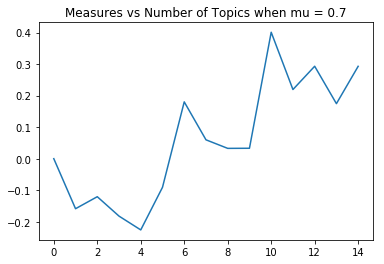

In [12]:
# After tuning \mu, we found that if \mu is less than 0.7, our measure will be dominated by continuity. 
# Between 0.7 ~ 0.9,a good combination
mu = 0.7
plt.plot(measure_standardization(c_v, continuity, mu))
plt.title('Measures vs Number of Topics when mu = {0}'.format(str(mu)))
plt.show()

The best model is built with 11 topics


array([ 0.        , -0.15862677, -0.12056734, -0.18209857, -0.22586611,
       -0.09077326,  0.18012431,  0.0598221 ,  0.03269569,  0.03303934,
        0.40090179,  0.2192736 ,  0.29307595,  0.17447633,  0.29283938])

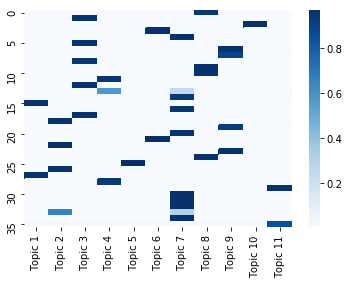

In [13]:
best_model_plot(lmlist, c_v, continuity, 0.7, indicator = 'std')

### Tuned with coherence value 

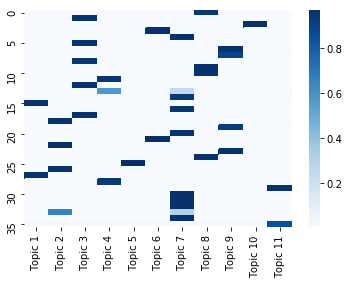

In [14]:
best_cv = lmlist[np.argmax(c_v)]
segment_topic_matrix = get_segment_topic_matrix(best_cv, len(corpus), np.argmax(c_v)+1)
xticks = ['Topic ' + str(i+1) for i in range(0, np.argmax(c_v) + 1)]
ax = sns.heatmap(segment_topic_matrix, yticklabels=5, xticklabels=xticks, cmap="Blues")

In [15]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_cv, corpus, dictionary)

/Users/yuweitu/anaconda/envs/python36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      23.544916        1       1  0.125201 -0.111466
2      14.250326        1       2 -0.115717 -0.102127
1      11.706746        1       3  0.160879  0.004129
7      11.375293        1       4 -0.065613 -0.051107
8       8.947446        1       5  0.066479  0.018715
5       7.196749        1       6 -0.024120  0.010393
0       6.050965        1       7  0.046026  0.091524
3       4.513103        1       8 -0.077147 -0.041215
4       4.320893        1       9  0.033245  0.036860
9       4.177597        1      10 -0.086851  0.101740
10      3.915959        1      11 -0.062382  0.042552, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
174   Default   9.000000      harmful   9.000000  30.0000  30.0000
61    Default  13.000000     platform  13.000000  29.0000  29.0000
74    Default  16.000000         heat  16.000000  28.0000  28.0000
240   Default   5.000000         zone   5.000000  27.0000  27.0000
28    Default  19.000000      tobacco  19.000000  26.0000  26.0000
77    Default   6.000000    portfolio   6.000000  25.0000  25.0000
7     Default  18.000000      product  18.000000  24.0000  24.0000
40    Default   2.000000       patent   2.000000  23.0000  23.0000
69    Default  10.000000         burn  10.000000  22.0000  22.0000
0     Default  22.000000            a  22.000000  21.0000  21.0000
151   Default   5.000000         fact   5.000000  20.0000  20.0000
140   Default   6.000000       actual   6.000000  19.0000  19.0000
170   Default   5.000000     compound   5.000000  18.0000  18.0000
56    Default   3.000000  development   3.000000  17.0000  17.0000
200   Default   4.000000      release   4.000000  16.0000  16.0000
111   Default   3.000000    reduction   3.000000  15.0000  15.0000
107   Default   4.000000         harm   4.000000  14.0000  14.0000
219   Default   2.000000        light   2.000000  13.0000  13.0000
178   Default   5.000000      aerosol   5.000000  12.0000  12.0000
11    Default   4.000000         work   4.000000  11.0000  11.0000
23    Default   3.000000        piece   3.000000  10.0000  10.0000
203   Default   2.000000         warm   2.000000   9.0000   9.0000
81    Default   6.000000         risk   6.000000   8.0000   8.0000
52    Default   3.000000         term   3.000000   7.0000   7.0000
14    Default   8.000000    cigarette   8.000000   6.0000   6.0000
36    Default   1.000000        legal   1.000000   5.0000   5.0000
30    Default   3.000000        world   3.000000   4.0000   4.0000
75    Default   6.000000     nicotine   6.000000   3.0000   3.0000
25    Default   2.000000    scientist   2.000000   2.0000   2.0000
166   Default   3.000000     thousand   3.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
25    Topic11   0.746539    scientist   2.588171   1.9969  -3.5990
273   Topic11   0.352822         lead   1.230737   1.9907  -4.3485
272   Topic11   0.339553        globe   1.227086   1.9553  -4.3868
271   Topic11   0.334839    establish   1.225789   1.9424  -4.4008
15    Topic11   0.655712        class   2.563183   1.8768  -3.7287
270   Topic11   0.288395       center   1.213012   1.8036  -4.5501
49    Topic11   0.387610    singapore   1.831181   1.6874  -4.2544
30    Topic11   0.697475        world   3.453386   1.6405  -3.6670
50    Topic11   0.349640  switzerland   1.820999   1.5899  -4.3575
77    Topic11   1.049002    portfolio   6.119741   1.4764  -3.2588
46    Topic11   0.346021     research   2.593151   1.2260  -4.3679
178   Topic11   0.716470      aerosol   5.725708   1.1617  -3.6401
56    Topic11   0.342370  development   3.192562   1.0074  -4.3785
61    Topic11   0.716471     platform  13.350729   0.3151  -3.6401
115   Topic11   0.059708      content   1.150099   0.2820  -6.1250
116   Topic11   0.059707      regular  

### Tuned with continuity

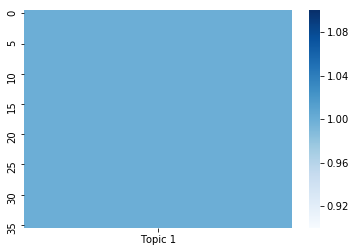

In [16]:
best_continuity = lmlist[np.argmin(continuity[1:])]
segment_topic_matrix = get_segment_topic_matrix(best_continuity, len(corpus), np.argmin(continuity[1:])+1)
xticks = ['Topic ' + str(i+1) for i in range(0, np.argmin(continuity[1:]) + 1)]
ax = sns.heatmap(segment_topic_matrix, yticklabels=5, xticklabels=xticks, cmap="Blues")

### Test: Whether the results from LDA model are stable ?

In [17]:
# don't fix random state and run 10 trials
num_trials = 10
num_topics = 10
c_vs = []
continuitys = []
for i in range(num_trials):
    lmlist, c_v, continuity = evaluate_LDA(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10,random_state = None)
    c_vs.append(c_v)
    continuitys.append(continuity)

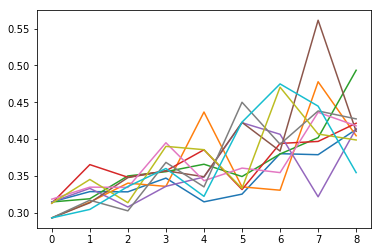

In [18]:
pd.DataFrame(c_vs).T.plot(legend = False)

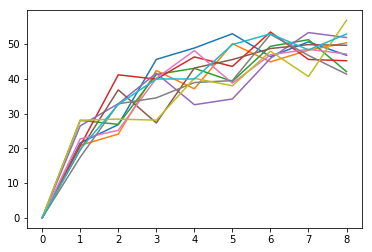

In [19]:
pd.DataFrame(continuitys).T.plot(legend = False)

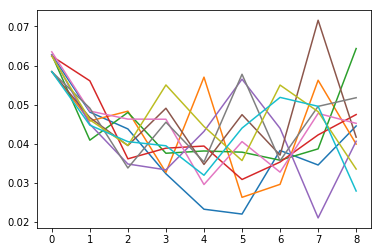

In [20]:
pd.DataFrame(measure_normalization(c_vs, continuitys, 0.7)).T.plot(legend = False)
# The results are unstable with random initialization

Potential Extension:  

* Definition of Continuity : 
add rewards for longer continuity: $(j*I_{max(r_{s,k}) =  max(r_{s,k-1} = ... max(r_{s,k-j}  )})$
    
    
* LDA Modeling: 
    
    DiscLDA: By using the topic mixture proportions as a new representation of documents, further obtain a supervised dimensionality reduction algorithm that uncovers the latent structure in a document collection. 
    
    other nonparametric topic model: cFTM - A nonparametric Bayesian contextual focused topic model, which infers a sparse (“focused”) set of topics for each document.